In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import scrublet 
from matplotlib.pyplot import rc_context
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"
%config InlineBackend.figure_format = 'retina'
sc.settings.set_figure_params(dpi=50, dpi_save=300, figsize=(5, 5))

In [2]:
os.chdir('/disk212/yupf/database/scRNA-seq/NewAtlas') #修改路径
concat_file='./atlas_concat.h5ad'
QC_file='./atlas_qc.h5ad'
reduction_file = './atlas_rd.h5ad'
harmony_file='./atlas_harm.h5ad'
scVI_file='./atlas_scvi.h5ad'
annotation_file ='./atlas_annotation.h5ad'

In [3]:
adata=sc.read_h5ad(concat_file)

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

### high variable genes

In [ ]:
sc.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=3,min_disp=0.5,batch_key='project')
print("Highly variable genes intersection: %d"%sum(adata.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata.var.highly_variable_nbatches.value_counts())
var_genes_batch = adata.var.highly_variable_nbatches > 0

Highly variable genes intersection: 2
Number of batches where gene is variable:
highly_variable_nbatches
0     4203
1     1524
2     1230
3     1089
4      997
      ... 
75      12
72      10
71       9
76       4
78       2
Name: count, Length: 79, dtype: int64


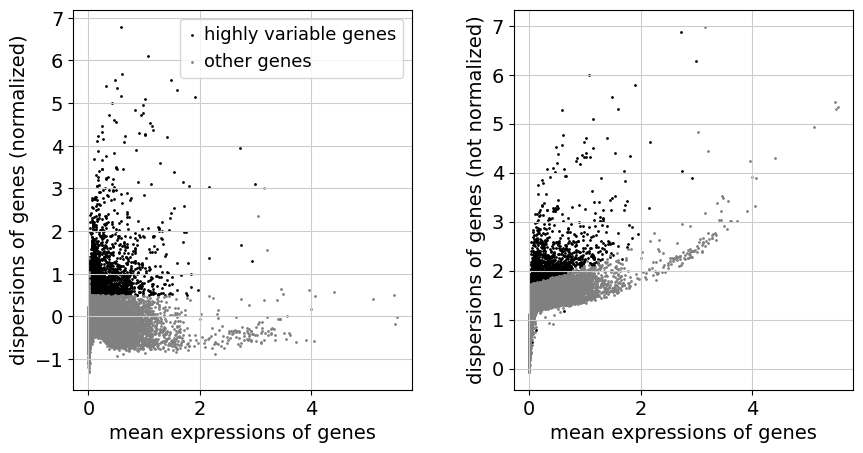

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
var_select = adata.var.highly_variable_nbatches > 20
var_genes = var_select.index[var_select]
len(var_genes)

3539

In [ ]:
adata.raw = adata
# adata = adata[:, adata.var.highly_variable]
adata = adata[:, var_genes]

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 589101 × 3539
    obs: 'doublet_score', 'predicted_doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'project'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts'

In [ ]:
cell_cycle_genes = [x.strip() for x in open('/disk212/yupf/code/scanpy_usage/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pp.regress_out(adata, ['S_score', 'G2M_score','total_counts', 'pct_counts_mt'])
sc.pp.scale(adata,max_value=10)

/disk211/public/anaconda3/envs/labBase/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


In [ ]:
# adata.write(QC_file)
adata=sc.read_h5ad(QC_file)

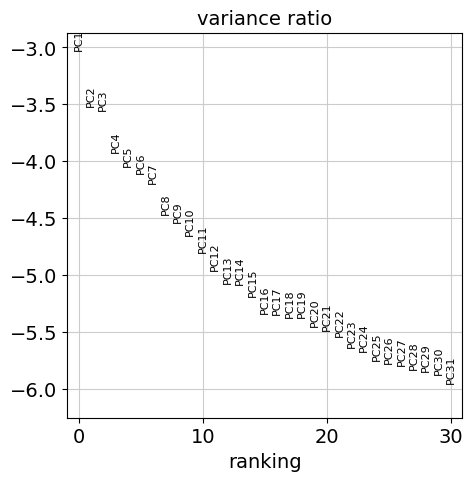

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
# sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

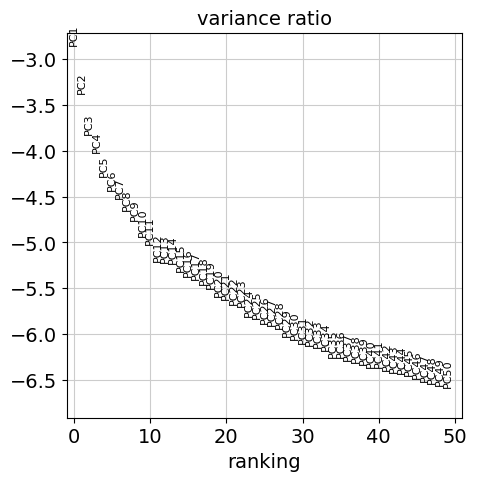

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

/disk211/public/anaconda3/envs/labBase/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


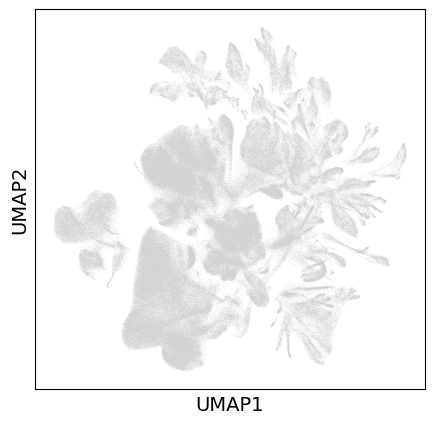

In [ ]:
sc.tl.umap(adata)
sc.pl.umap(adata)

/disk211/public/anaconda3/envs/labBase/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


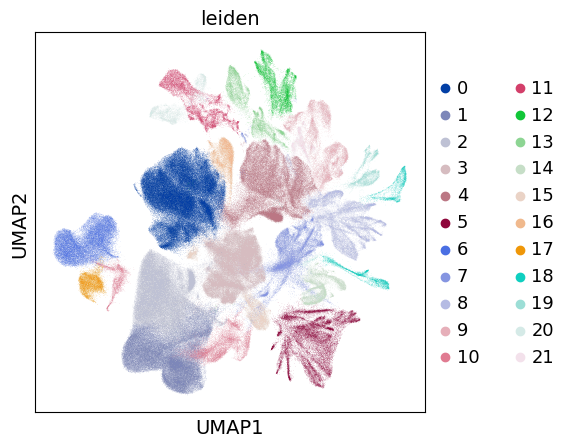

In [ ]:
sc.tl.leiden(adata, resolution = 0.25)
sc.pl.umap(adata, color=['leiden'])

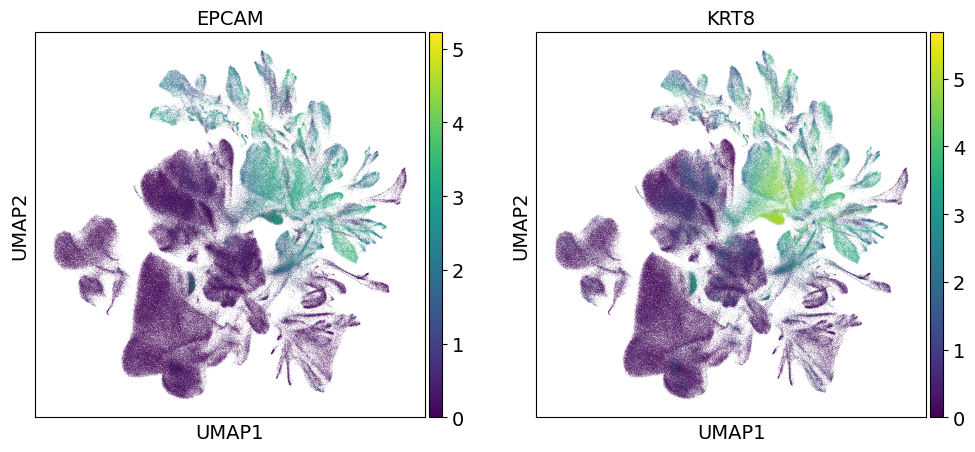

In [ ]:
sc.pl.umap(adata,color=['EPCAM', 'KRT8'])#上皮

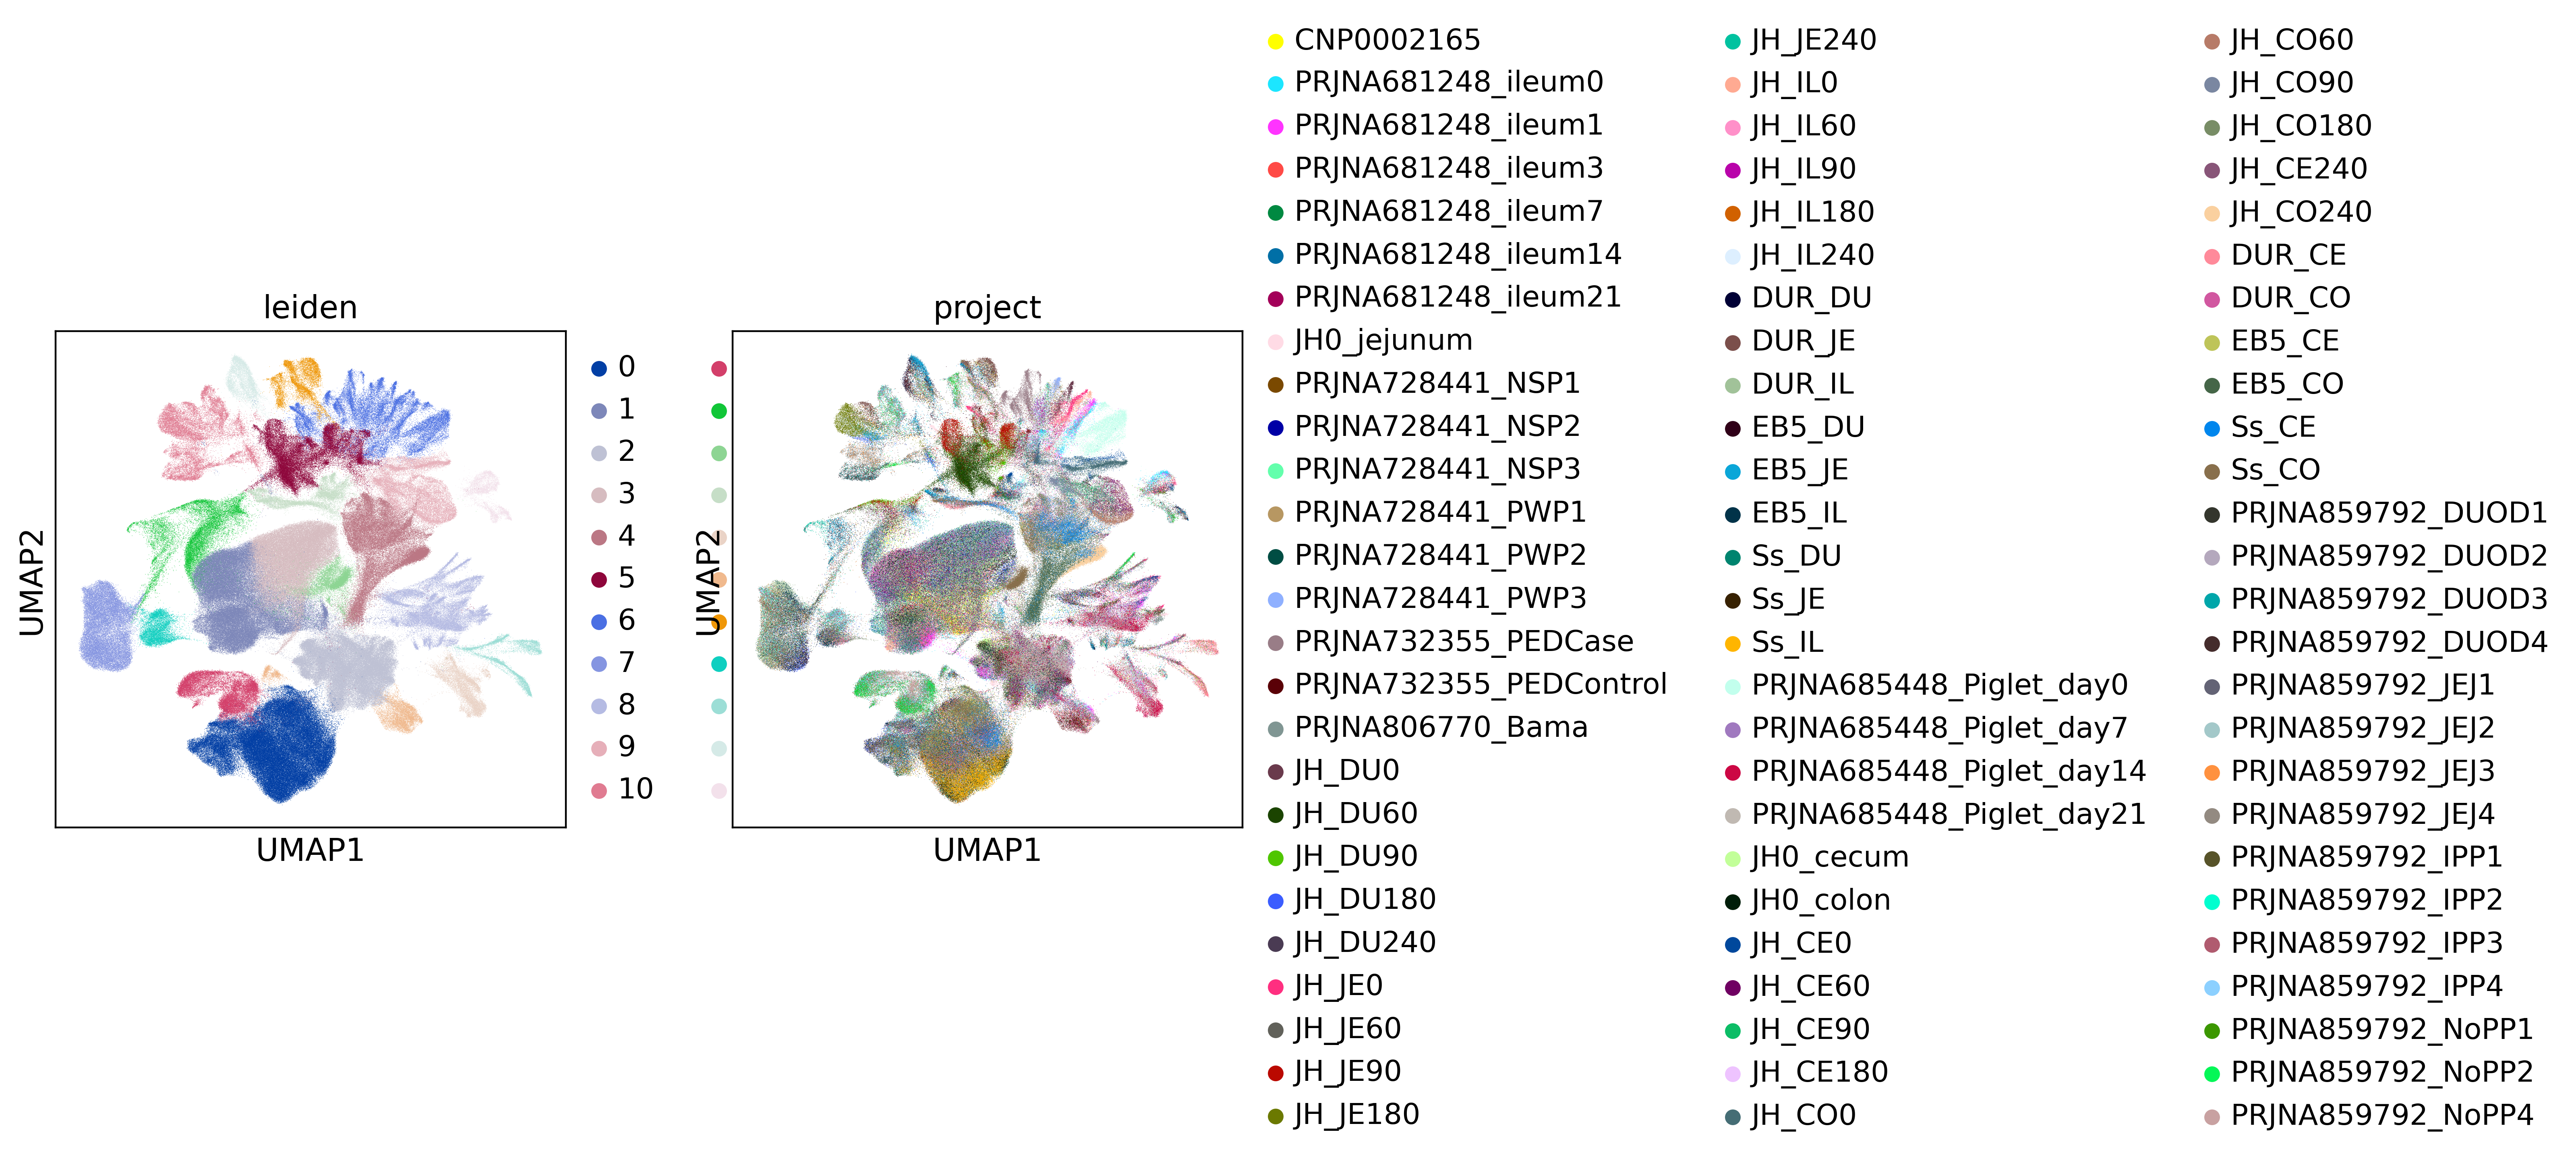

In [ ]:
sc.pl.umap(adata, color=['leiden','project'])

In [ ]:
adata=adata.raw.to_adata()

In [ ]:
adata

AnnData object with n_obs × n_vars = 589101 × 19346
    obs: 'doublet_score', 'predicted_doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'project', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [ ]:
adata.write(reduction_file)